In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
#ensemble
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix

#warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('train.csv')

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [4]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d2

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'Credit Risk'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'Employment Type'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade','Employment.Type'],axis=1)

In [5]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [6]:
numerical=['disbursed_amount','asset_cost','PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES','Age','NEW.ACCTS.IN.LAST.SIX.MONTHS', 
        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
categorical=['manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES', 'Credit Risk','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH',
       'Employment Type']

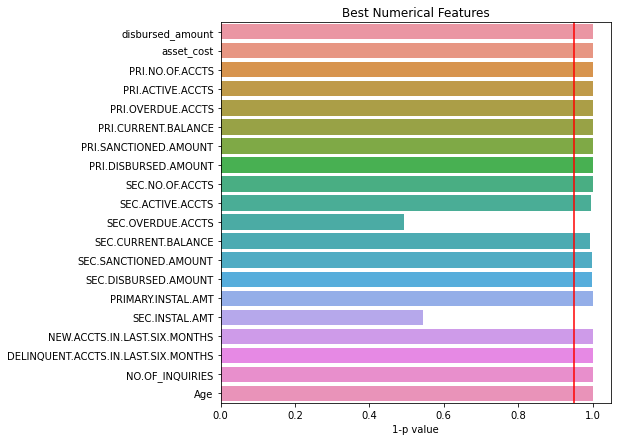

In [7]:
#T Test for numerical columns
p=[]
from scipy.stats import ttest_ind

for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    p.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05),color='r')
plt.xlabel('1-p value')
plt.show()

For visual purpose, I redid the graph to show acceptance of 'Alternative Hypothesis' for T Test. So, the ones crossing the red lines show
statistical significance. But for vehicle loans and educational loans, it is observed that Banks don't want to compromise of loosing any 
details of Secondary Account holder, since them also being the guarantor for the loan in case of a default.
But, there is a problem in this T Test, as will be observed in the next cell


In [8]:
for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    print(np.std(df1[i],ddof=1),np.std(df2[i],ddof=1))

13140.699007454981 12150.255527172329
19015.002867400774 18680.502608619492
5.261141650236005 5.04013362644165
2.0082420121201543 1.6699657272094286
0.5320262425886055 0.6034839757822386
994631.7352945457 720451.2837834031
1234346.7457205276 4525738.059420681
1240214.826412385 4527095.229863031
0.6516570890275873 0.527358347626265
0.32337474128357524 0.2880958812264165
0.1112491367023999 0.11046343401346002
184110.75765814638 106044.4250689912
195212.28973392927 130717.86808523617
194597.53945599656 130392.76612443924
157963.98513600946 124665.51133351553
16588.052553508056 11045.628444420758
0.9729689997390004 0.8856611487937556
0.37023513218495563 0.43087164170425074
0.6655358308421763 0.8351467924444976
9.837771953398061 9.65876884479994
0.9729689997390004 0.8856611487937556
0.37023513218495563 0.43087164170425074


The above observations are Standard Deviations of Columns (i.e., Defaulters vs Non-defaulters). T Test for independence runs on the assumption that samples under observations should have equal Standard Deviations. Although the difference observed above seems less, it still doesn't seem acceptable. Hence, we'll go with a non-parametric test.

We'll use SelectKBest library to narrow down choices of features. This will make use of Annova test.

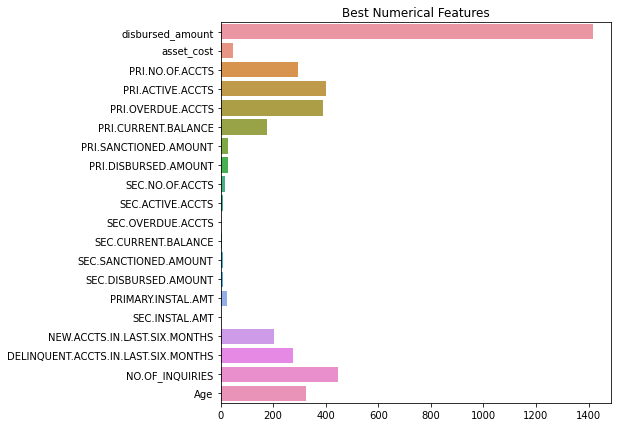

In [9]:
from sklearn.feature_selection import SelectKBest,f_classif
n = SelectKBest(score_func=f_classif, k=10)
numcols=n.fit(df[numerical],df['loan_default'])
plt.figure(figsize=(7,7))
sns.barplot(x=numcols.scores_,y=numerical)
plt.title('Best Numerical Features')
plt.show()

The graph shows that Secondary Account informations are insignificant. Again of course, banks can't afford to drop Secondary Account informations, so we'll have to combine the Primary and Secondary Account informations. 

In [10]:
df.loc[:,'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df.loc[:,'PRI Inactive accounts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'SEC Inactive accounts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'Total Inactive accounts'] = df['PRI Inactive accounts'] + df['SEC Inactive accounts']
df.loc[:,'Total Overdue Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

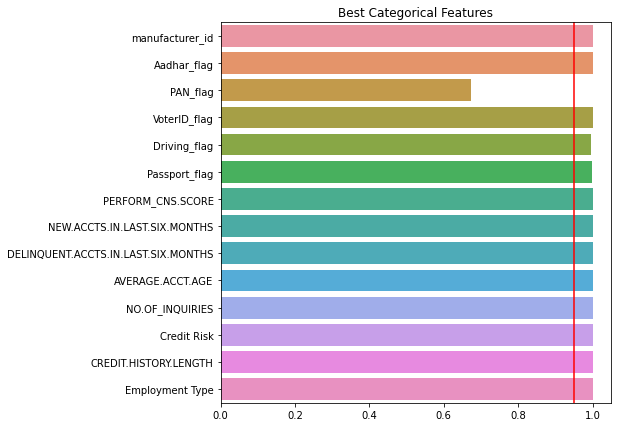

In [11]:
#Chi Square test for Categorical Columns
from scipy.stats import chi2_contingency
l=[]
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df['loan_default'],df[i]))[1]
    l.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r')
plt.show()

Here too, the graph shows acceptance of Alternate Hypothesis. Again, we can observe some multicollinearity between credit score and PAN Card,
since PAN Card is mandatory to obtain credit score. Hence, the Chi Square test deemed it surplus to our research. But for argument sake, we'll
keep it.

In [12]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [13]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [14]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','PRI Inactive accounts','SEC Inactive accounts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [15]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment','Age']

In [16]:
len(nums)

16

In [17]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print('train accuracy :',lr.score(X_train,y_train))
print('test accuracy :',lr.score(X_test,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))

train accuracy : 0.7829443590042093
test accuracy : 0.7827783893519379
precision : 0.0 

recall : 0.0 

f1 score: 0.0 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54756
           1       0.00      0.00      0.00     15191

    accuracy                           0.78     69947
   macro avg       0.39      0.50      0.44     69947
weighted avg       0.61      0.78      0.69     69947



Now this is a bad start to model building. The model isn't able to predict the 1s here. Maybe class-imbalance here. Plus, there is huge difference between macro and weighted scores. So, lets see the distribution of the target variable.

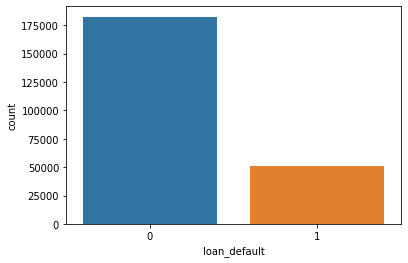

In [18]:
sns.countplot(df['loan_default'])

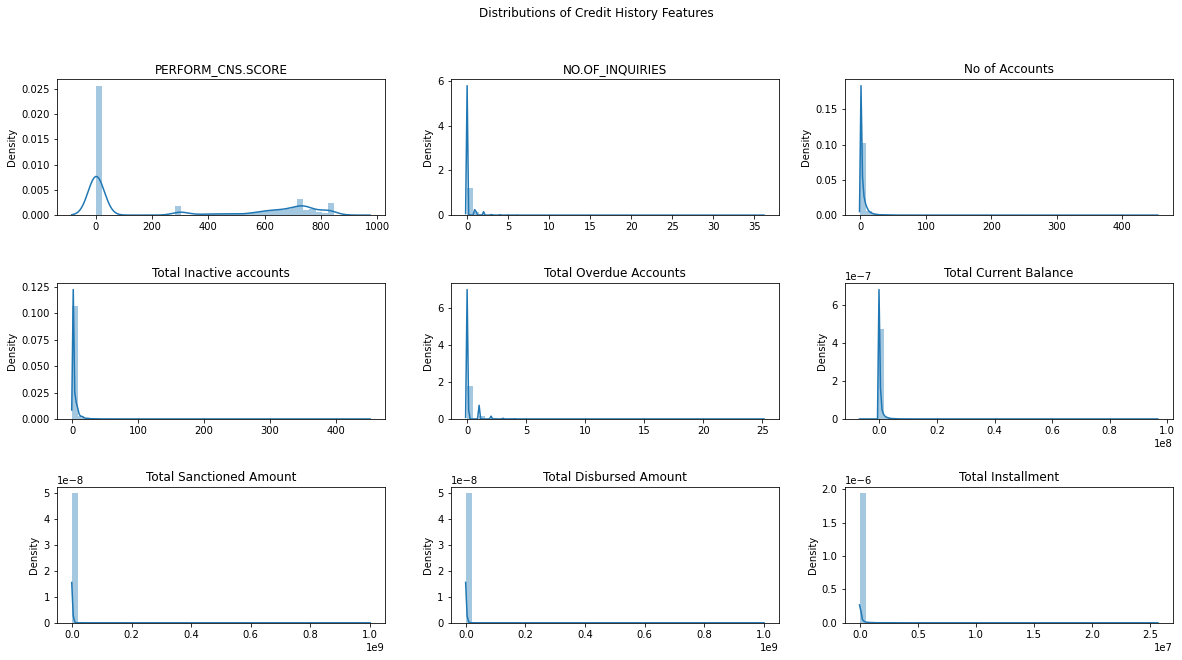

In [19]:
n=['PERFORM_CNS.SCORE','NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment']
data=df[n]
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Credit History Features')

for ax, feature, name in zip(axes.flatten(), data.values.T, data.columns):
    sns.distplot(feature, ax=ax)
    ax.set(title=str(name))
plt.show()

Maximum number of customers are applying for loan for the first time, which explains why all the above columns have so many zero values. Also, there are many notable outliers, which makes the problem more complicated.

Let's deal with outliers. Instead of using popular methods, we'll try to preserve the outlier records instead of removing them. We'll use RobustScaler to bring the observations closer to the median value (here, zero in those credit history columns).

In [20]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])

Now, for the zero observations, we'll make a new feature that counts the features having zero. This will act as yardstick between people who have a credit history and those who dont. Of course, people with no credit history will likely have more than 9 features as zero, unlikely in case of customers with credit history.

In [21]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

Now let's try on our base model. We'll use XGBoost to reduce bias and variance errors, and do some hyperparameter tuning.

In [22]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [23]:
from sklearn.model_selection import GridSearchCV

In [25]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 45.93121052,  45.58736801,  45.52278487,  76.11023005,
          75.28952169,  74.79864931, 115.74217216, 114.14007219,
         112.25491921, 161.95307668, 157.70226733, 123.75873137]),
  'mean_score_time': array([0.66491493, 0.77866673, 0.75645804, 1.19764821, 1.20911296,
         1.20521108, 1.55897498, 1.65128215, 1.69267893, 2.23112265,
         2.15731621, 0.91133889]),
  'mean_test_score': array([0.95507032, 0.9554161 , 0.95558955, 0.99245568, 0.99240869,
         0.99221617, 0.99809507, 0.99802974, 0.9980626 , 0.99898281,
         0.9990306 , 0.99901325]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, Fals

In [26]:
param_test2b = {
 'max_depth':range(7,10,2)
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch2b.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4, param_grid={'max_depth': range(7, 10, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [27]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([114.41227261, 109.51873716]),
  'mean_score_time': array([1.55458649, 0.85791556]),
  'mean_test_score': array([0.99809507, 0.99898281]),
  'param_max_depth': masked_array(data=[7, 9],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 7}, {'max_depth': 9}],
  'rank_test_score': array([2, 1], dtype=int32),
  'split0_test_score': array([0.99859654, 0.99919884]),
  'split1_test_score': array([0.99781288, 0.99887751]),
  'split2_test_score': array([0.99787579, 0.99887209]),
  'std_fit_time': array([ 0.35347653, 27.34919798]),
  'std_score_time': array([0.17689902, 0.29547713]),
  'std_test_score': array([0.00035552, 0.00015277])},
 {'max_depth': 9},
 0.9989828131604358)

In [28]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.4}, 0.999164583587025)

In [29]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [31]:
xgb4.fit(X_train,y_train)
y_pred=xgb4.predict(X_test)
print("accuracy train:",xgb4.score(X_train,y_train),"\n")
print("accuracy test:",xgb4.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 0.9999509824946234 

accuracy test: 0.9983558980370852 

precision : 0.9986109273713454 

Recall : 0.9938121256006847 

f1 score: 0.9962057474677489 

Confusion Matrix 
 [[54735    21]
 [   94 15097]]


Voila! we smashed the record set on all these scores.

In [32]:
import sklearn.metrics as metrics

In [33]:
probs = xgb4.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

In [34]:
print(fpr, tpr)

[0.         0.         0.         ... 0.99853897 0.9985755  1.        ] [0.00000000e+00 6.58284511e-05 9.21598315e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


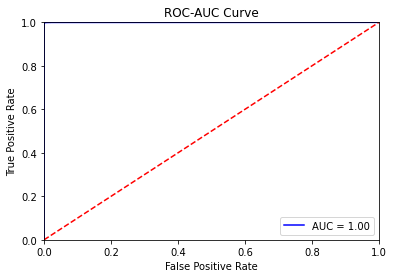

In [35]:
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()

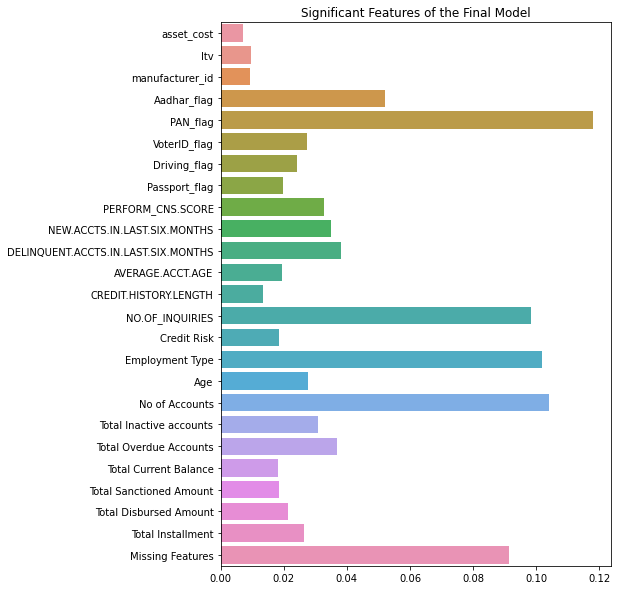

In [36]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb4.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()